## Imports

In [1]:
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt

import time as ti

# Question 1

## Task 1

### Read the file and store it as an numpy array

In [2]:
first_row = np.loadtxt("ME278_Assignment1_RowData_PowerMethod.txt", skiprows=3)

### Get the next row given the previous row

In [3]:
def get_next_row(current_row):
    next_row = np.zeros(len(current_row))
    next_row[:len(current_row)-1] = current_row[1:]
    next_row[-1] = current_row[0] * 2
    return next_row

# 'Test'

# current_row = np.ones(4)

# print(current_row)
# for i in range(0, 3):
#     current_row = get_next_row(current_row=current_row)
#     print(current_row)

## Task 2

### Matrix-vector product

In [4]:
def mat_vec_pdt(first_row, x_vector):
    length = len(x_vector)
    if len(first_row) != length:
        raise ValueError("Incompatible matrix-vector product")
    
    else:
        product_vector = np.zeros(length)
        product_vector[0] = np.dot(first_row, x_vector)
        for i in range(1, length):
            first_row = get_next_row(first_row)
            product_vector[i] = np.dot(first_row, x_vector)
        return product_vector


# 'Test'

# first_row = [1, 1, 1, 1]
# x_vector = [1, 0, 1, -2]
# print(mat_vec_pdt(first_row, x_vector))

## Task 3

### Power method

In [5]:
def power_iteration(first_row, guess_vector, MAX_STEPS=20, TOL=1e-5):
    
    guess_vector = np.multiply(guess_vector, (1 / norm(guess_vector)))
    eigen_values = [-999]

    for i in range(1, MAX_STEPS + 1):
        guess_vector = mat_vec_pdt(first_row=first_row, x_vector=guess_vector)
        guess_vector = np.multiply(guess_vector, (1 / norm(guess_vector)))

        eigen_values.append(np.dot(guess_vector, mat_vec_pdt(first_row=first_row, x_vector=guess_vector)))
        eigen_error = abs(eigen_values[-1] - eigen_values[-2])

        if eigen_error < TOL:
            break
    
    return (guess_vector, eigen_values, eigen_error, i)


# 'Test'

# x = [1, 0, 0, 0]
# print(*power_iteration([1, 1, 1, 1], x), sep='\n')

# print()
# x = [1, 2, 3, 4]
# print(*power_iteration([1, 1, 1, 1], x), sep='\n')

# print()
# x = [1, -10, 0, 46.9]
# print(*power_iteration([1, 1, 1, 1], x), sep='\n')


### Deflation method

In [6]:
def deflation_method(first_row, guess_vector, num_eigens=3, MAX_STEPS=30, TOL=1e-5):

    largest_ev_solution = power_iteration(first_row=first_row, guess_vector=guess_vector, MAX_STEPS=MAX_STEPS, TOL=TOL)
    eigen_vectors, eigen_values, iteration_count = [largest_ev_solution[0]], [largest_ev_solution[1][-1]], [largest_ev_solution[-1]]

    guess_eigen_values = [-999]
    guess_vector = guess_vector / norm(guess_vector)

    for _ in range(2, num_eigens + 1):
        
        for i in range(1, MAX_STEPS + 1):
            first_vector = mat_vec_pdt(first_row, guess_vector)
            
            second_vector = np.zeros(len(first_row))
            for j in range(len(eigen_vectors)):
                second_vector = np.add(second_vector, np.multiply(eigen_vectors[j], np.dot(eigen_vectors[j], first_vector)))

            guess_vector = np.subtract(first_vector, second_vector)
            guess_vector = guess_vector / norm(guess_vector)

            guess_eigen_values.append(np.dot(guess_vector, mat_vec_pdt(first_row=first_row, x_vector=guess_vector)))
            eigen_error = abs(guess_eigen_values[-1] - guess_eigen_values[-2])

            if eigen_error < TOL:
                eigen_vectors.append(guess_vector)
                eigen_values.append(guess_eigen_values[-1])
                iteration_count.append(i)
                break
    
    return eigen_vectors, eigen_values, iteration_count

eigen_vectors, eigen_values, iteration_count = deflation_method(first_row, first_row, num_eigens=3, MAX_STEPS=100)

for i in range(len(eigen_values)):
    # print(f'ev: {eigen_values[i]} \nEV: {eigen_vectors[i]} \nIter: {iteration_count[i]}\n')
    print(f'ev: {eigen_values[i]} \nIter: {iteration_count[i]}\n')


ev: 79.2238108154686 
Iter: 4

ev: -10.33255479077789 
Iter: 82

ev: 9.517971547774035 
Iter: 2



## Task 4

### Largest eigen value plot

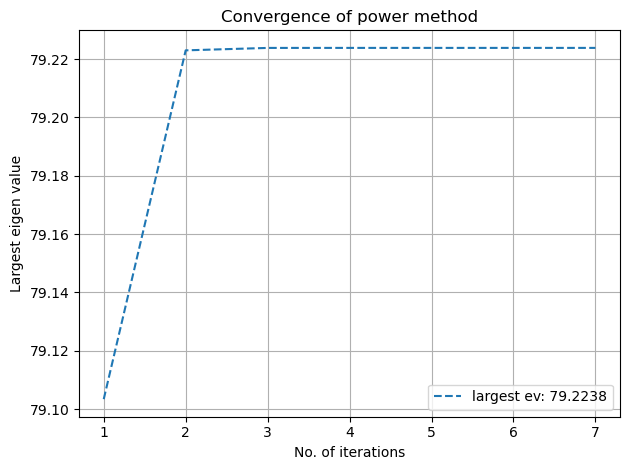

In [7]:
start_time_power = ti.time()
largest_ev_solution = power_iteration(first_row=first_row, guess_vector=first_row, MAX_STEPS=100, TOL=1e-10)
end_time_power = ti.time()

eigen_values, iterations = largest_ev_solution[1][1:], largest_ev_solution[-1]

x = [_ for _ in range(1, iterations + 1)]

plt.plot(x, eigen_values, '--', label=f'largest ev: {eigen_values[-1]:.4f}')
plt.legend()
plt.xlabel('No. of iterations')
plt.ylabel('Largest eigen value')
plt.title('Convergence of power method')
plt.tight_layout()
plt.grid()

### Comments

The number of iterations used for convergence depends on the tolerance. For a tolerance of $10^{-5}$, the scheme converges in just $4$ iterations. Even for a tolerance of 10^{-10}$, the scheme converges in just $7$ iterations. When we observe the largest and the second largest eigen value, they are sufficiently farther apart. That is why the convergence is so fast. 

But the second largest eigen value converges at about $80$ iterations with the deflation scheme. This is due to the fact that the second and third largest eigen values are not well-separated in terms of the absolute value. But while finding the third largest eigen value with deflation scheme, the scheme again converges at about $5$ iterations as the nearby eigen value/vector (the second largest) component is removed from the search space.

## Task 5

### Constructing the matrix

In [8]:
dim = len(first_row)
given_matrix = np.empty((dim, dim))

given_matrix[0] = first_row

for i in range(1, len(first_row)):
    given_matrix[i] = get_next_row(given_matrix[i-1])

### Computing the ev using numpy

In [10]:
start_time_numpy = ti.time()
eigen = np.linalg.eig(given_matrix)
end_time_numpy = ti.time()

print('Power method:')
print(f'No. of eigen values/vectors: 1 \nTime taken: {(end_time_power - start_time_power):.8f} s\n')

print('Numpy subroutine:')
print(f'No. of eigen values/vectors: {len(eigen[0])} \nTime taken: {(end_time_numpy - start_time_numpy):.8f} s')

Power method:
No. of eigen values/vectors: 1 
Time taken: 0.01110911 s

Numpy subroutine:
No. of eigen values/vectors: 100 
Time taken: 0.06917310 s
[ 79.2238109  -10.33260307   9.5180252 ]


### Comments

The numpy subroutine fully diagonalizes the given square matrix whereas the power method only finds the eigen vector corresponding to the eigen value with the largest absolute magnitude. Upon multiple trials, it is seen that the power method takes $1.758 \times 10^{-2} s$ whereas the numpy routine takes anywhere between $2.7 \times 10^{-2} s$ and $5.0 \times 10^{-2} s$ with the caveat that the numpy routine obtains all $100$ eigenvalues whereas the power method only obtains the largest one. There is also a $3^{rd}$ or $4^{th}$ decimal difference in terms of eigenvalues produced by numpy and power method. This might be due to different tolerances.

This highlights the point discussed in the class that the utility of power method is limited in the sense that it can be used to obtain the largest (or modified to obtain a handful of the first few largest) eigen pairs of a really large matrix where diagonalizing the matrix is computationally too heavy. Also, the time for the numpy routine is bound to grow cubically or near cubically with the matrix size whereas the power method scales quadratically. So, the larger the matrix in hand, power method and its variants become more and more attractive if the objective is to find a handful of eigen pairs without diagonalizing the matrix (and if the matrix is not in some special form such as symmetric).

## Task 6

### Case 1: Forward cyclic permutation with the first row

If we perform the forward cyclic permutation on a given first row without changing any of the entries in any way (without multiplying by 2), we obtain a circulant matrix with all the right diagonals filled by the same number. For example, if:

$R_1 = [1\quad 2\quad 3\quad 4]$

$R_2 = [4\quad 1\quad 2\quad 3]$

$R_3 = [3\quad 4\quad 1\quad 2]$

$R_4 = [2\quad 3\quad 4\quad 1]$


It can be clearly seen that all the entries in a given downward right diagonals are all the same.

### Case 2: Forward cyclic permutation with the last row

If we perform the forward cyclic permutation on a given last row, we obtain a circulant matrix with all the left diagonals filled by the same number. For example, if:

$R_4 = [1\quad 2\quad 3\quad 4]$

Then, the matrix formed will be:

$R_1 = [2\quad 3\quad 4\quad 1]$

$R_2 = [3\quad 4\quad 1\quad 2]$

$R_3 = [4\quad 1\quad 2\quad 3]$

$R_4 = [1\quad 2\quad 3\quad 4]$


It can be clearly seen that all the entries in a given upward left diagonals are all the same.

## Task 7

### Total storage used in power method implementation

The first row of the matrix and an initial guess vector are stored. For a square matrix of size $n$, this comes to $2 \times n$. The eigen value at each iteration is stored to produce the plot, this comes to $k$ for $k$ iterations. The guess vector is reused to store the eigen value and the matrix is never explicitly stored, so the storage requirement goes down significantly. Other single variables like error, loop counter are ignored here. All the variables are stored as $numpy.float64$ datatype, so, each variable is of $64$ bits or $8$ bytes.

The total storage comes down to $2n + k$. For this problem, $k \approx 10$ and $n = 100 \implies 2n + k \approx 210$ memory units, which is $210 \times 8 = 1680$ bytes.

# Question 2

## Solution for A

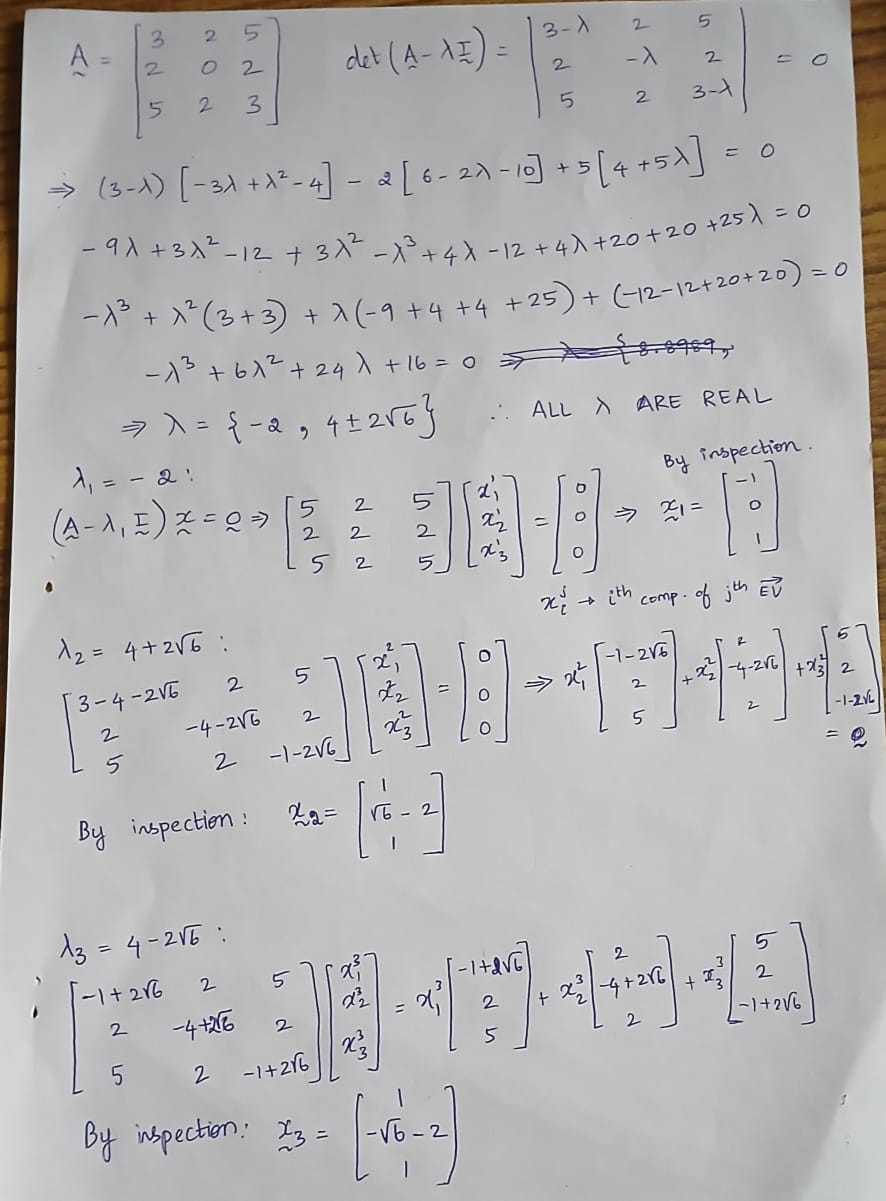

## Solution for B

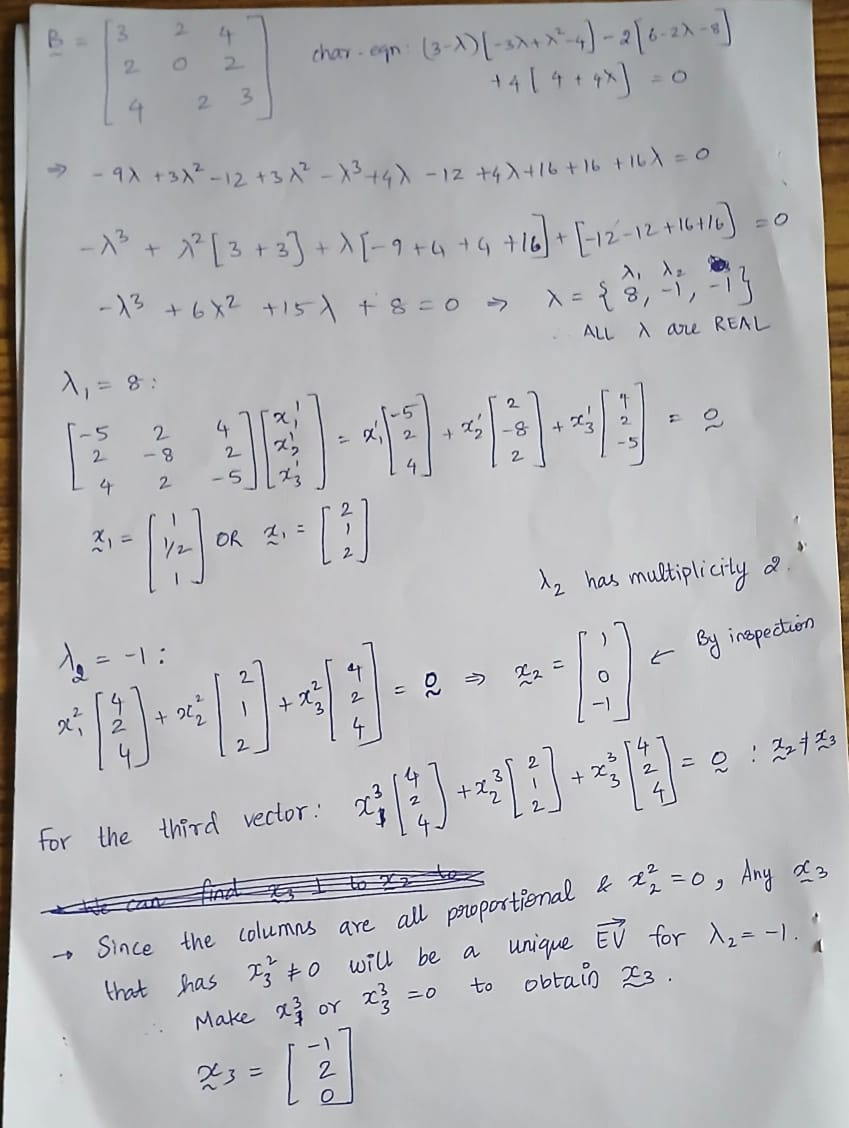

## Orthogonality of eigenvectors of A and B

The obtained eigenvectors are orthogonal for A but not B. In this procedure, the eigenvectors of A and B both have been normalized. The eigenvectors of B has been orthogonalized using a projection of one of the non-orthogonal vectors onto the other.

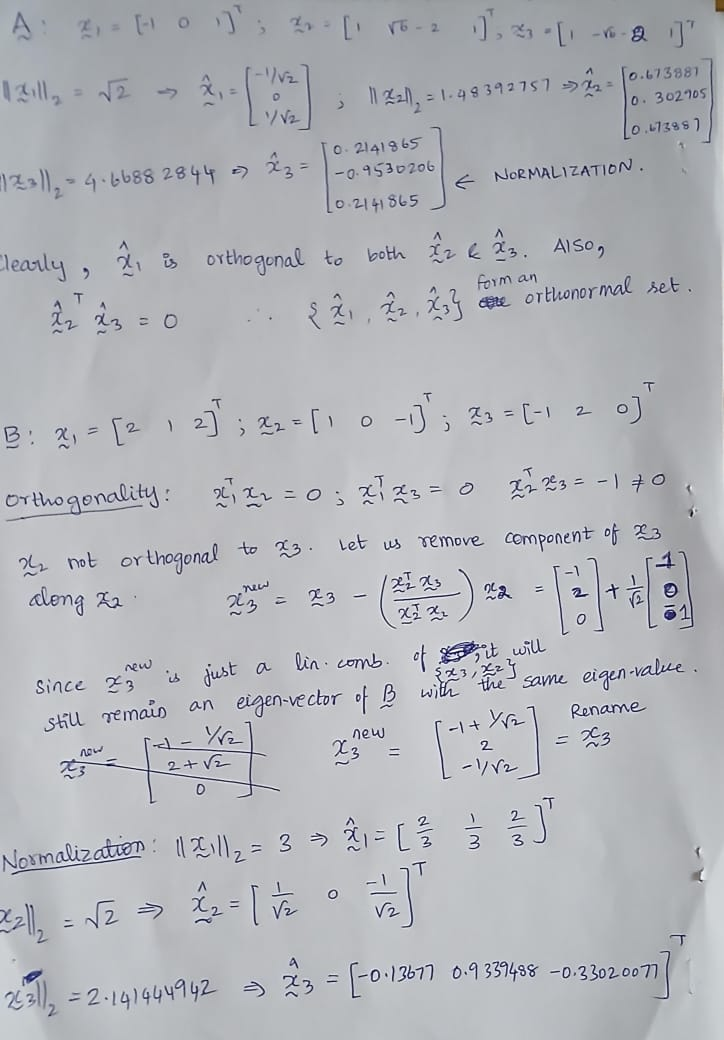